# 强化学习第一次实验

## 1. MC

### 1.1 创建环境

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "./" not in sys.path:
  sys.path.append("./") 
from lib.envs.blackjack import BlackjackEnv
from collections import defaultdict
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()
env.seed(20211116)

state, reward, done, _ = env.step(action)
* action: int(bool) 类型,表示是否继续要牌;  
* state: 由三个分量组成的 tuple，分别为 （玩家牌面总点数，庄家所亮牌的点数，是否有可用的Ace）;  
（这里“可用的Ace”是指：将其计算为11点的时候总点数不会超过21点的情形）
* reward: +1或者-1，平局便为0（玩家叫牌过程中也为0）;  
* done: bool 类型,表示牌局是否结束（玩家停止叫牌或玩家点数已经超过21点便结束该局）  

### 1.2 制定策略：$\epsilon$ 贪婪策略  
其中字典 Q 记录了所有历史状态下，做出不同动作的期望（平均）得分，由此得出之后遇到相同状态时应选取的最优策略。  
对于此题，就是以概率 $1-\epsilon/2$ 选取期望得分更高的策略（Stick or Hit）

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

如果我们选择贪婪策略 (greedy policy)来进行迭代，即每一次选择的行为，都要保证下一步到达具有最大价值的状态。这在基于模型的动态规划算法中确实是个好方法，能收敛至最优策略 (价值)，但是这在不基于模型、基于采样的蒙特卡罗或时序差分学习中通常是不行的。因为动态规划算法是考虑了一个状态的后续所有状态价值的。而蒙特卡罗或时序差分则仅考虑到已经采样过的状态，有一部分事实存在的状态并没有经历过，有些状态虽然经历过，但由于经历次数不多对其价值的估计也不一定准确。如果存在一些价值更高的未被探索的状态使用贪婪算法将始终无法探索到这些状态，而已经经历过但价值较低的状态也很难再次被经历，如此将很难得到最优策略。

In [4]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
        score, usable_ace, dealer_score))

### 1.3 根据算法流程得到主程序

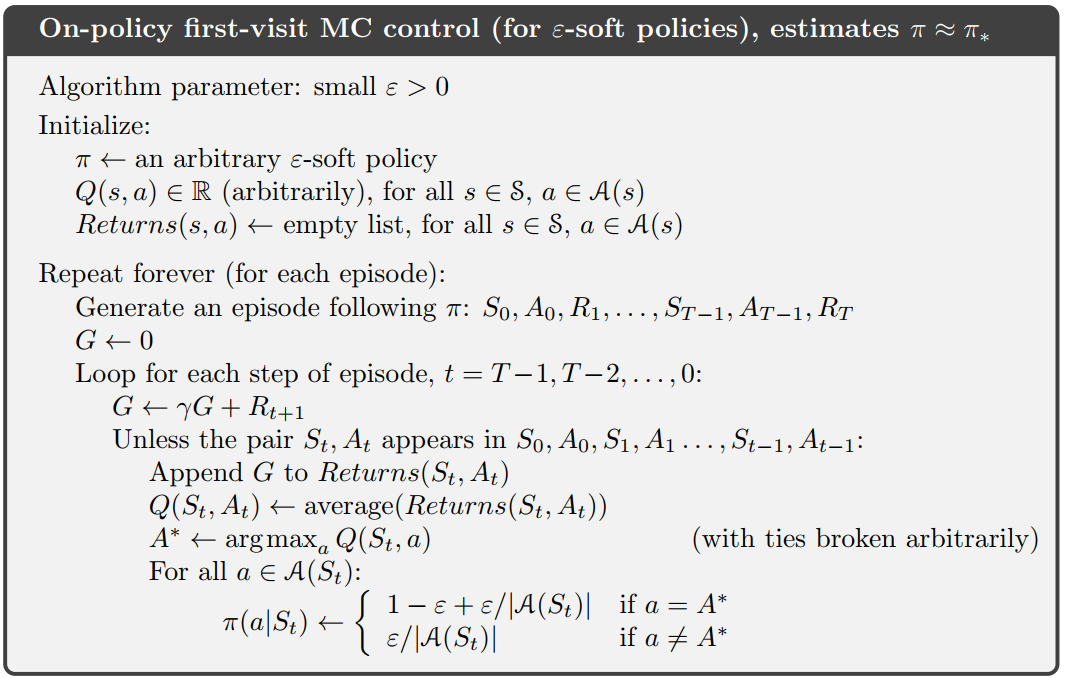

根据上图的算法流程，写出相应的代码

In [5]:
def mc(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    total_reward = [0]   # 记录玩家每个对局结束后的总得分
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 100000 == 0:
            print('*'*50)
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="\n")
            sys.stdout.flush()

        # step 1 : Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            # 每隔100000局输出3个对局详情，看看有没有进步
            if i_episode % 100000 < 3:
                print_observation(state)
                print("Taking action: {}".format(["Stick", "Hit"][action]))
            next_state, reward, done, _ = env.step(action)
            episode.append((next_state, action, reward))
            if done:
                total_reward.append(total_reward[-1] + reward)
                if i_episode % 100000 < 3:
                    print_observation(state)
                    print("Game end. Reward: {}\n".format(float(reward)))
                break
            state = next_state

        # step 2 : Find the first (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i, x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(episode[first_occurence_idx:])])
            # step 3 : Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # The policy is improved implicitly by changing the Q dictionary

    return Q, policy, total_reward

In [6]:
Q, policy, total_reward = mc(env, num_episodes=500000, epsilon=0.1)

**************************************************
Episode 0/500000.
Player Score: 20 (Usable Ace: False), Dealer Score: 5
Taking action: Stick
Player Score: 20 (Usable Ace: False), Dealer Score: 5
Game end. Reward: 0.0

Player Score: 21 (Usable Ace: True), Dealer Score: 7
Taking action: Stick
Player Score: 21 (Usable Ace: True), Dealer Score: 7
Game end. Reward: 1.0

Player Score: 20 (Usable Ace: False), Dealer Score: 7
Taking action: Stick
Player Score: 20 (Usable Ace: False), Dealer Score: 7
Game end. Reward: 1.0

**************************************************
Episode 100000/500000.
Player Score: 17 (Usable Ace: False), Dealer Score: 2
Taking action: Hit
Player Score: 18 (Usable Ace: False), Dealer Score: 2
Taking action: Stick
Player Score: 18 (Usable Ace: False), Dealer Score: 2
Game end. Reward: 1.0

Player Score: 19 (Usable Ace: False), Dealer Score: 10
Taking action: Stick
Player Score: 19 (Usable Ace: False), Dealer Score: 10
Game end. Reward: 1.0

Player Score: 15 (Usable

根据上述对局情况，还是可以看出计算机玩得越来越溜了（以我个人玩21点的经验来看）  
不过这样还是被够直观，于是我就把游戏前期和后期的 total_rewards 变化曲线画出来看看。

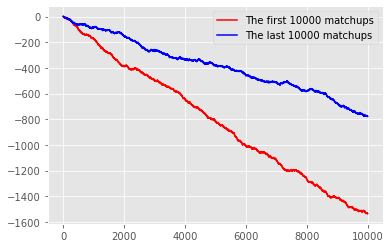

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# plt.subplot
k = 10000
y1 = total_reward[:k]
y2 = np.array(total_reward[-k:])-total_reward[-k]
plt.plot(y1, color='red', label='The first {} matchups'.format(k))
plt.plot(y2, color='blue', label='The last {} matchups'.format(k))
plt.legend()
plt.show()

结果非常的 amazing 啊！  
前期一直输得很惨，后期明显稳多了。（虽然还是干不过庄家）  
说明这个学的真不错，很有进步！

### 1.4 查看值函数

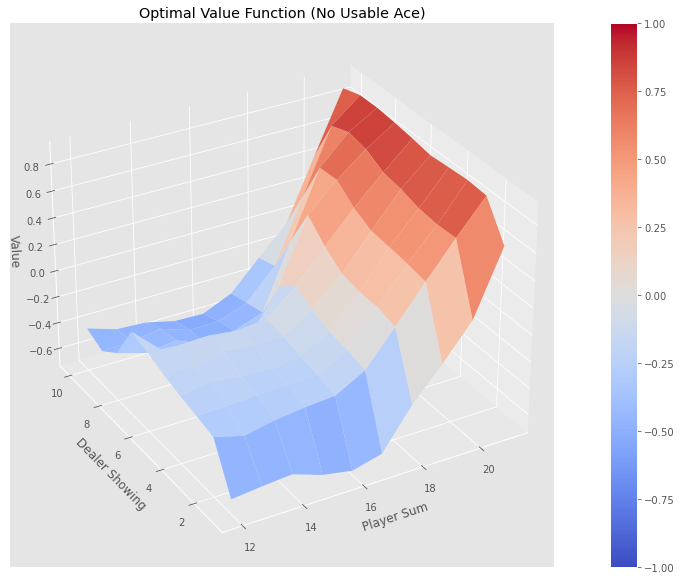

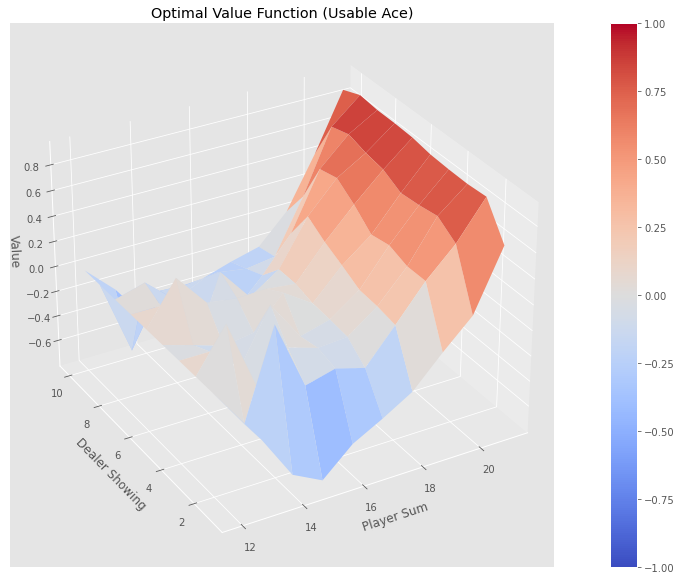

In [8]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")
# plot_value_function(V, title="Optimal Value Function")

根据 value_funtion 的图像可以看出以下几点：  
* 玩家得分小于17时，赢面就比较小，而当得分达到20及以上，基本就稳赢了；  
* 庄家所亮牌面点数好像对玩家的输赢影响不大，但是当庄家展示点数为1时，还是可以看出玩家基本赢不了；  
* 有可用的Ace明显可以大幅提高获胜的概率。  
这三点都很符合我们玩这个游戏的直觉。

## 2. TD SARSA

### 2.1 创建环境

In [9]:
import itertools
import pandas as pd

from lib.envs.cliff_walking import CliffWalkingEnv

env = CliffWalkingEnv()

依然选用 $\epsilon$-贪婪策略

### 2.2 根据算法流程得到主程序

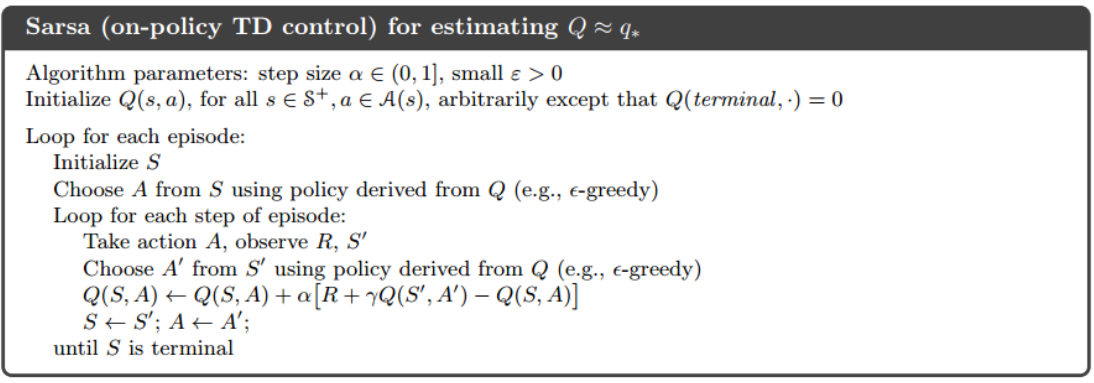

In [10]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        # Reset the environment
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        # One step in the environment
        for t in itertools.count():
            # step 1 : Take a step( 1 line code, tips : env.step() )
            next_state, reward, done, _ = env.step(action)

            # step 2 : Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # step 3 : TD Update
            # compute Q value      
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

In [11]:
Q, stats = sarsa(env, 500)

Episode 500/500.

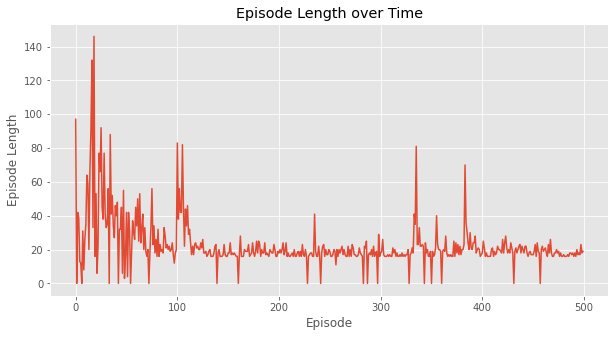

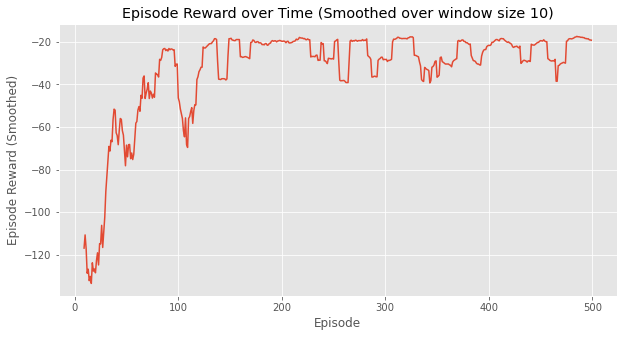

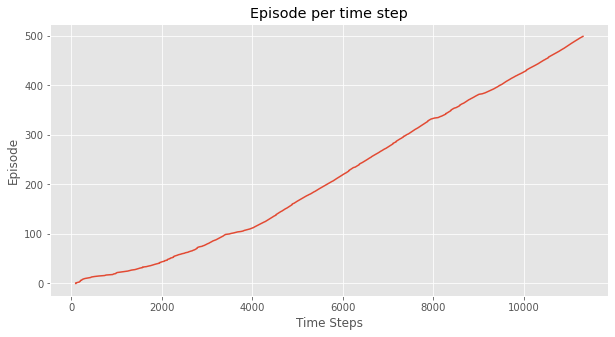

In [12]:
plotting.plot_episode_stats(stats)
plt.show()

## 3. TD Q-Learning

### 3.1 创建环境

In [13]:
env = CliffWalkingEnv()

依然选用 $\epsilon$-贪婪策略

### 3.2 根据算法流程得到主程序

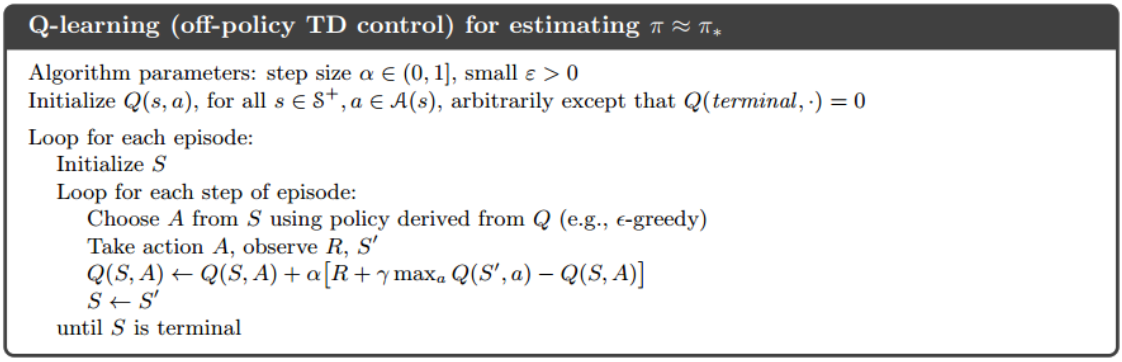

In [14]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()

        # One step in the environment
        # total_reward = 0.
        for t in itertools.count():
            
            # step 1 : Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # step 2 : TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state

    return Q, stats

In [15]:
Q, stats = q_learning(env, 500)

Episode 500/500.

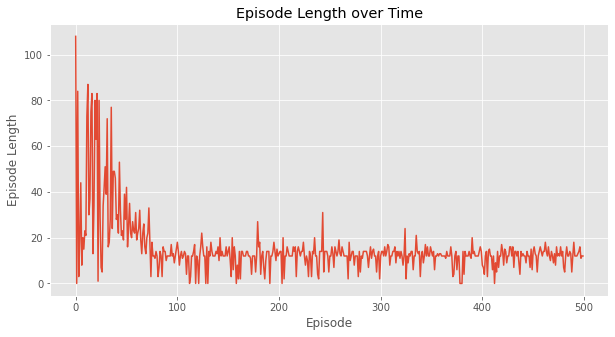

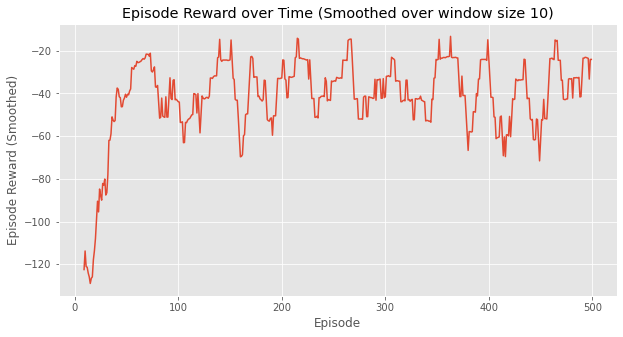

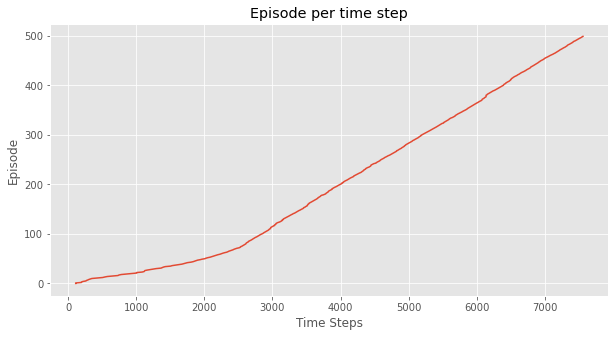

In [16]:
plotting.plot_episode_stats(stats)
plt.show()